# Optimizing Experiments with `Pyomo.DoE`

**Prepared by:** [Jialu Wang](https://github.com/jialuw96), [Prof. Alex Dowling](https://github.com/adowling2/), [Hailey Lynch](https://github.com/hglynch), and Andrew Marquardt (amarquar@nd.edu, 2024) at the University of Notre Dame.
    

## Introduction and Learning Objectives

This notebook uses **design of experiments** for a reactor kinetics experiment with Pyomo.DoE. The user will be able to learn concepts involved in Model-Based Design of Experiments (MBDoE) and practice using Pyomo.DoE from methodology in the notebook. Results will be interpreted throughout the notebook to connect the material with the Pyomo implementation.

The general process we will follow throughout this notebook:
* Import Modules
    * Step 0: Import Pyomo and Pyomo.DoE Module
* Problem Statement
    * Step 1: Mathematical Model for the Reaction Kinetics Example
* Implementation in Pyomo
    * Step 2: Implement Mathematical Model
    * Step 3: Generate an Experiment
    * Step 4: Run the DOE Module to get Optimal Design Parameters
* Methodology
    * Step 5: Method for Computing FIM
    * Step 6: Running a Full Factorial Design Experiment
* Visualizing Results
    * Step 7: Evaluating the Full Factorial Heat Maps
* Key Takeaways

## Step 0: Import Pyomo and Pyomo.DoE Module

In [1]:
# IPOPT installer
import sys

if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/optimization/main/notebooks/helper.py"
    import helper
    helper.install_idaes()
    helper.install_ipopt()
else:
    sys.path.insert(0, '../')
    import helper

    # Import solver
    import idaes
helper.set_plotting_style()

In [2]:
#F# Imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyomo.environ as pyo
import pyomo.common.unittest as unittest
from pyomo.contrib.doe import DesignOfExperiments
from pyomo.dae import ContinuousSet, DerivativeVar

## Step 1: Mathematical Model for the Reaction Kinetics Example

### Reaction Kinetics

Consider two chemical reactions that convert molecule $A$ to desired product $B$ and a less valuable side-product $C$:

$$A \overset{k_1}{\rightarrow} B \overset{k_2}{\rightarrow} C$$

**Goal:**
* Design a large-scale continuous reactor that maximizes the production of $B$.
 <br>

The rate laws for these two chemical reactions are:

$$r_A = -k_1 C_A$$

$$r_B = k_1 C_A - k_2 C_B$$

$$r_C = k_2 C_B$$

Here, $C_A$, $C_B$, and $C_C$ are the concentrations of each species. \\

The rate constants $k_1$ and $k_2$ depend on temperature as follows:

$$k_1 = A_1 \exp \left({\frac{-1000 E_1}{R T}} \right)$$

$$k_2 = A_2 \exp \left({\frac{-1000 E_2}{R T}}\right)$$

where:
* $A_1$ [$s^{-1}$], $A_2$ [$s^{-1}$], $E_1$ [$kJ/mol$], and $E_2$ [$kJ/mol$] are fitted model parameters.
* $R$ [$J/mol K$] is the ideal-gas constant.
* $T$ [$K$] is absolute temperature.

**Objective:**
* Using the Pyomo ecosystem, we would like to perform **uncertainty quantification** and **design of experiments** on a small-scale batch reactor to infer parameters $A_1$, $A_2$, $E_1$, and $E_2$.

### Batch Reactor

The concentrations in a batch reactor evolve with time and are modeled by the following differential equations:

$$ \frac{d C_A}{dt} = r_A = -k_1 C_A(t) $$

$$ \frac{d C_B}{dt} = r_B = k_1 C_A(t) - k_2 C_B(t) $$

$$ \frac{d C_C}{dt} = r_C = k_2 C_B(t) $$

We have now established a linear system of differential equations. Next we can write our initial conditions where we assume the feed is only species $A$ such that:

$$C_A(t=0) = C_{A0}, \quad C_B(t=0) = 0, \quad C_C(t=0) = 0$$

When $k_1$ and $k_2$ are at constant temperature, we have the following analytic solution:

$$C_A(t) = C_{A0} \exp(-k_1 t)$$

$$C_B(t) = \frac{k_1}{k_2 - k_1} C_{A0} \left[\exp(-k_1 t) - \exp(-k_2 t) \right]$$

$$C_C(t) = C_{A0} - \frac{k_2}{k_2 - k_1} C_{A0} \exp(-k_1 t) + \frac{k_1}{k_2 - k_1} \exp(-k_2 t) C_{A0} = C_{A0} - C_{A}(t) - C_{B}(t)$$

See the following for more information on batch reactors:
* Batch Reactor: [AIChE](https://www.aiche.org/ccps/resources/glossary/process-safety-glossary/batch-reactor-0#:~:text=A%20reactor%20in%20which%20the,the%20end%20of%20the%20batch) / [Wikipedia](https://en.wikipedia.org/wiki/Batch_reactor)

## Step 2: Implement Mathematical Model

This mathematical model is comprised of a system of dynamic algebraic equations (DAEs). This system will be solved using Pyomo.DAE.

See the following notebooks from CBE 60499 regarding Pyomo.DAE:
* [Dynamic Optimization Overview](https://ndcbe.github.io/optimization/notebooks/2/DAE-modeling.html)
* [Dynamic Optimization Example](https://ndcbe.github.io/optimization/notebooks/2/Pyomo-DAE.html)

The experiment class build design contains 5 functions:
* the class init__() containing assignments to the input values the module needs.  These can be specified different than the given defaults in the experiment build call; otherwise, the defaults will be saved as class variables.
* create_model() containing the initial essential build scaffolding for the model.  The time, data collection points, concentrations (both initial and time-dependent), kinetic expressions, and mass balances are given here.  Note the concentration differentials are grouped together in a conditional function; this can also be done with separate expressions if that is more intuitive.
* finalize_model() containing essential fixes of the arrhenius parameters (and other values), discretization, and time bin behavior (namely that the end points of each data collection period are continuous- analogous to the technique used on splines).
* label_experiment() containing the necessary setup for the experiment to recognize inputs, outputs, measurement errors (this can be constant or functional), and the arrhenius parameters meant to be tested.  Note that each section is necessary- the experiment will not run if inputs, outputs, errors, and unknowns are not declared.
* get_labeled_model() containing calls to the previous 3 functions and a return of the final, completed model.  This is what is used by the DOE module- all parts must be properly built previously and then collected by this master function.  Practically, this function doesn't have any real effect on the model except to combine everything done in the discrete sections.

Note all the functions are in one code block below- the notebook struggled to recognize the class components if this was not the case.

In [3]:
class Reactor_Experiment():
    def __init__(self,t_control=[0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0.875, 1],control_val=[500,300,300,300,300,300,300,300,300],t_range=[0,1],CA_init=5,C_init=[5,0,0],theta_pe={'A1': 85,'A2': 370,'E1': 8,'E2': 15,},NFE=32,ncp=3):
        """
        Arguments:
        ---------
        t_control: time-dependent design (control) variables, a list of control timepoints
        control_val: control design variable values T at corresponding timepoints
        t_range: time range, h
        CA_init: time-independent design (control) variable, an initial value for CA
        C_init: An initial value for C
        theta_pe: optimized parmest parameters for the arrhenius kinetic equations
        NFE: number of finite elements in the discretizer
        ncp: number of collocation points per finite element in the discretizer
        """
        self.t_range = t_range
        self.CA_init = CA_init
        self.C_init = C_init
        self.NFE = NFE
        self.ncp = ncp
        self.t_control = t_control
        self.control_val = control_val
        self.theta_pe = theta_pe
        self.model = None

    def create_model(self):
        # model build
        m = self.model = pyo.ConcreteModel()

        # concentration intialization
        m.CA_init = self.CA_init

        # Time-independent design variable
        m.t0 = pyo.Set(initialize=[0])
        m.CA0 = pyo.Var(m.t0, initialize=self.CA_init, bounds=(0, 5.0), within=pyo.NonNegativeReals)  # mol/L

        # parameters
        m.R = pyo.Param(mutable=False,initialize=8.314)

        # variables
        m.t = ContinuousSet(bounds=(self.t_range[0], self.t_range[1]))

        # Parameter list
        para_list = ['A1', 'A2', 'E1', 'E2']
        m.para_list = para_list
        # Define parameters as Param
        m.A1 = pyo.Var(within=pyo.NonNegativeReals)
        m.A2 = pyo.Var(within=pyo.NonNegativeReals)
        m.E1 = pyo.Var(within=pyo.NonNegativeReals)
        m.E2 = pyo.Var(within=pyo.NonNegativeReals)

        # Concentration variables under perturbation
        m.C_set = pyo.Set(initialize=['CA', 'CB', 'CC'])
        m.CA = pyo.Var(m.t, initialize=self.C_init[0], within=pyo.NonNegativeReals)
        m.CB = pyo.Var(m.t, initialize=self.C_init[1], within=pyo.NonNegativeReals)
        m.CC = pyo.Var(m.t, initialize=self.C_init[2], within=pyo.NonNegativeReals)

        # Time derivatives
        m.dCAdt = DerivativeVar(m.CA, wrt=m.t)
        m.dCBdt = DerivativeVar(m.CB, wrt=m.t)
        m.dCCdt = DerivativeVar(m.CC, wrt=m.t)

        # Time-dependent design variable, initialized with the first control value
        m.t_control = self.t_control
        # Control time points
        m.t_con = pyo.Set(initialize=m.t_control)
        # Controls
        controls = {}
        for i, t in enumerate(self.t_control):
            controls[t] = self.control_val[i]
        def T_initial(m, t):
            if t in m.t_con:
                return controls[t]
            else:
                # count how many control points are before the current t;
                # locate the nearest neighbouring control point before this t
                j = -1
                for t_con in m.t_con:
                    if t > t_con:
                        j += 1
                neighbour_t = m.t_control[j]
                return controls[neighbour_t]
        m.T = pyo.Var(m.t, initialize=T_initial, bounds=(300, 700), within=pyo.NonNegativeReals)

        m.kp1 = pyo.Var(m.t, within=pyo.NonNegativeReals)
        m.kp2 = pyo.Var(m.t, within=pyo.NonNegativeReals)
        @m.Constraint(m.t)
        def kp1_cons(m,t):
            return m.kp1[t] == m.A1 * pyo.exp(-m.E1 * 1000 / (m.R * m.T[t]))
        @m.Constraint(m.t)
        def kp2_cons(m,t):
            return m.kp2[t] == m.A2 * pyo.exp(-m.E2 * 1000 / (m.R * m.T[t]))

        @m.Constraint(m.C_set,m.t)
        def dCdt_rule(m, y, t):
            """
            Calculate CA in Jacobian matrix analytically

            Arguments:
            z: scenario No.
            y: CA, CB, CC
            t: timepoints

            Return:
            m: Pyomo model
            """
            if y == 'CA':
                return m.dCAdt[t] == -m.kp1[t] * m.CA[t]
            elif y == 'CB':
                return (
                    m.dCBdt[t]
                    == m.kp1[t] * m.CA[t] - m.kp2[t] * m.CB[t]
                )
            elif y == 'CC':
                return m.dCCdt[t] == m.kp2[t] * m.CB[t]

        @m.Constraint(m.t)
        def alge(m, t):
            """
            The algebraic equation for mole balance

            Arguments:
            z: m.pert
            t: time

            Return:
            m: Pyomo model
            """
            return m.CA[t] + m.CB[t] + m.CC[t] == m.CA0[0]

    def finalize_model(self):
        m = self.model

        # fix arrhenius parameters (any changes necessary will be done automatically by pyomo- this is necessary to ensure that the model DoF is 0)
        m.A1.fix(self.theta_pe['A1'])
        m.A2.fix(self.theta_pe['A2'])
        m.E1.fix(self.theta_pe['E1'])
        m.E2.fix(self.theta_pe['E2'])

        # fix the starting concentration value (similar to arrhenius parameters, though not strictly necessary in the same way)
        m.CA0.fix(self.CA_init)

        # Boundary Conditions
        m.CB[0.0].fix(0.0)
        m.CC[0.0].fix(0.0)

        @m.Constraint(m.t)
        def T_control(m, t):
            """
            T at interval timepoint equal to the T of the control time point at the beginning of this interval
            Count how many control points are before the current t;
            locate the nearest neighbouring control point before this t

            Arguments:
            m: model
            t: time

            Return:
            m: Pyomo model
            """
            if t in m.t_con:
                return pyo.Constraint.Skip
            else:
                j = -1
                for t_con in m.t_con:
                    if t > t_con:
                        j += 1
                neighbour_t = m.t_control[j]
                return m.T[t] == m.T[neighbour_t]


        # Discretization
        discretizer = pyo.TransformationFactory('dae.collocation')
        discretizer.apply_to(m, nfe=self.NFE, ncp=self.ncp, wrt=m.t)
        for t in m.t:
            m.dCdt_rule["CC", t].deactivate()

    def label_experiment(self):
        m = self.model

        # Concentration measurement labels
        m.experiment_outputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_outputs.update((m.CA[t], None) for t in m.t_control)
        m.experiment_outputs.update((m.CB[t], None) for t in m.t_control)
        m.experiment_outputs.update((m.CC[t], None) for t in m.t_control)

        # measurement values
        m.measurement_error = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.measurement_error.update((m.CA[t], 1e-4) for t in m.t_control)
        m.measurement_error.update((m.CB[t], 1e-4) for t in m.t_control)
        m.measurement_error.update((m.CC[t], 1e-4) for t in m.t_control)

        # Design variables
        m.experiment_inputs = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.experiment_inputs.update((m.CA0[t], None) for t in m.t0)
        m.experiment_inputs.update((m.T[t], None) for t in m.t_control)

        # unkown parameter labels
        m.unknown_parameters = pyo.Suffix(direction=pyo.Suffix.LOCAL)
        m.unknown_parameters.update((k,pyo.value(k)) for k in [m.A1,m.A2,m.E1,m.E2])

    def get_labeled_model(self):
        if self.model is None:
            self.create_model()
            self.finalize_model()
            self.label_experiment()
        return self.model

## Step 3: Generate an Experiment

Recall the unknown model parameters, $\theta = (A_1, A_2, E_1, E_2)$.

Our goal is to **maximize** the precision of $\theta$ by measuring the model outputs called $y$ for the initial conditions at each time point such that $y(t)=(C_A(t), C_B(t), C_C(t))$.

The code block below generates an experiment and then runs the DOE module on the generated experiment class.  The given parameters are the default parameters for DesignOfExperiments, the step size is a generally acceptable 0.001, and the finite difference formula used is the most robust first order basic method (central difference).

In [4]:
experiment = Reactor_Experiment()
fd_formula = "central"
step_size = 10**-3
objective_option = "determinant"
scale_nominal_param_value = True
doe_obj = DesignOfExperiments(
        experiment,
        fd_formula=fd_formula,
        step=step_size,
        objective_option=objective_option,
        scale_constant_value=1,
        scale_nominal_param_value=scale_nominal_param_value,
        prior_FIM=None,
        jac_initial=None,
        fim_initial=None,
        L_diagonal_lower_bound=1e-7,
        solver=None,
        tee=False,
        get_labeled_model_args=None,
        _Cholesky_option=True,
        _only_compute_fim_lower=True,)

## Step 4: Run the DOE Module to get Optimal Design Parameters

The ultimate goal of an experiment of this type is to determine the optimum design parameters.  Later, we will see what it looks like to run an ensemble of experiments (which can give more information), but for now, one will suffice.

In [5]:
doe_obj.run_doe()

In [6]:
for i,j in enumerate(doe_obj.results['Experiment Design']):
    if i == 0:
        print("Ideal CA initial concentration: {} M".format(j))
    else:
        print("Ideal Temperature at checkpoint {}: {} K".format(i-1,round(j,2)))

Ideal CA initial concentration: 5.0 M
Ideal Temperature at checkpoint 0: 455.51 K
Ideal Temperature at checkpoint 1: 300.0 K
Ideal Temperature at checkpoint 2: 300.0 K
Ideal Temperature at checkpoint 3: 300.0 K
Ideal Temperature at checkpoint 4: 300.0 K
Ideal Temperature at checkpoint 5: 300.0 K
Ideal Temperature at checkpoint 6: 300.0 K
Ideal Temperature at checkpoint 7: 511.39 K
Ideal Temperature at checkpoint 8: 700.0 K


From here, the optimum parameters are to start the experiment at an A concentration of 5.0 M and an initial temperature of about 500K, with all subsequent temperatures being dropped to 300K.


### Understanding the Output for Running an Experiment

Let's take some time to understand exactly what just happened there from a theory standpoint.  When we generate experiments, we will get a class containing for the FIM, determinant, and eigenvalues.

See the following notebooks from CBE 60499 and CBE 60258 for more information on determinants and eigenvalues:
* Determinant: [CBE 60499](https://ndcbe.github.io/optimization/notebooks/3/Math-Primer.html?#determinant) / [CBE 60258](https://ndcbe.github.io/data-and-computing/notebooks/04/Linear-Algebra-in-Numpy.html?#determinant)

* Eigenvalue: [CBE 60499](https://ndcbe.github.io/optimization/notebooks/3/Math-Primer.html?#eigenvectors-and-eigenvalues) / [CBE 60258](https://ndcbe.github.io/data-and-computing/notebooks/04/Linear-Algebra-in-Numpy.html?#eigenvectors-and-eigenvalues)

### Fisher Information Matrix (FIM):

**Objective**:
* The FIM measures the information content for the unknown parameters $\theta$ from the model output $y_i$ such that:

$$y_i=f(\psi_i, \theta)$$

In order to quantify the uncertainty of the estimated parameters for parameter estimation, consider the covariance matrix for the parameters:

$$V(\hat{\theta},\psi) = \left[\sum_{r}^{N_{r}}\sum_{r}^{N_{r}} \tilde{\sigma}_{(r,r')}Q_{r}^{T}Q_{r'}+V_{\theta}(\hat{\theta})^{-1}\right]^{-1}$$

where:
* $\hat{\theta}$: estimated parameters.
* $\tilde{\sigma}$: element in the inverse of the observational covariance matrix.
* $r,$ $r'$: measurements.
* $Q$: dynamic sensitivity.
* $V_{\theta}$: prior information.

The inverse of $V$ estimates the FIM such that: <br>

$$V(\hat{\theta},\psi) = [M(\hat{\theta},\psi)]^{-1}$$

where:
* $\psi$: design vector from a DAE system <br>

For sequential design of experiments, consider prior information such that after $N_e$ experiments, the FIM is calculated by:
$$M= \sum_{k=1}^{N_e-1}M_k+M_{N_e}(\hat{\theta},\psi_{N_e}) = K+M_{N_e}(\hat{\theta},\psi_{N_e})$$

where:
* $N_e - 1$: previous experiments
* $K$: constant matrix encoding information from all $N_e - 1$

**Key Takeaways**: \\
In regards to parameter estimation,
* A **large** FIM value denotes **more** information about $\theta$ is gained from the model.

See the following notebook from CBE 60258 for more information on FIM:
* [Computing FIM](https://ndcbe.github.io/data-and-computing/notebooks/16/Reaction-MBDoE.html#fisher-information-matrix)

## Step 5: Method for Computing FIM

This method computes a FIM-based MBDoE optimization problem with no degrees of freedom.

### Optimality Conditions

In our results, we will use the four optimality conditions below:



| **Optimality Condition**  	| **Definition**                                                    	| **Computation**      	| **Geometry**                                                                       	|
|-----------------------	|---------------------------------------------------------------	|------------------	|--------------------------------------------------------------------------------	|
| D-Optimality        	| Maximizes the determinant of $M$ or minimizes the determinant of $V$ 	| Determinant      	| Minimizes the volume of the  confidence ellipsoid                              	|
| A-Optimality          	| Maximizes the trace of $M$ or minimizes the trace of $V$             	| Trace            	| Minimizes the dimensions of the enclosing box around the confidence ellipsoid 	|
| E-Optimality          	| Minimizes the variance of the  most uncertain parameter       	| Eigenvalue       	| Minimizes the size of the major axis of the confidence ellipsoid               	|
| Modified E-Optimality 	| Reduces the correlations between parameters                   	| Condition Number 	| Transforms the confidence ellipsoid into a round sphere                        	|

See the following notebooks from CBE 60499 and CBE 60258 for more information on condition numbers:
* Condition Number: [CBE 60499](https://ndcbe.github.io/optimization/notebooks/3/Math-Primer.html?%20number#condition-number) / [CBE 60258](https://ndcbe.github.io/data-and-computing/notebooks/04/Condition-Number.html?#condition-number)

For additional information on condition number and trace:
* Wikipedia: [Condition Number](https://en.wikipedia.org/wiki/Condition_number) / [Trace](https://en.wikipedia.org/wiki/Trace_(linear_algebra))

Now that our analysis is complete, we can take a further look at our results.  First, the initial FIM matrix, with only the diagonal populated.

In [7]:
doe_obj.fim_initial

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Next, let's take a look at a single FIM matrix.  After the experiment is run, the FIM is populated with values showing that the experiment has yielded information about the 4 arrhenius parameters.

In [8]:
doe_obj.compute_FIM()

array([[  186908.66237351,   158693.0963409 ,  -388214.6707347 ,
         -749813.95132776],
       [  158693.0963409 ,   344092.54462273,  -294525.36474362,
        -1598447.48509604],
       [ -388214.6707347 ,  -294525.36474362,   821096.94785898,
         1399756.9225552 ],
       [ -749813.95132776, -1598447.48509604,  1399756.9225552 ,
         7502382.99492581]])

## Step 6: Running a Full Factorial Design Experiment (Exploratory Analysis)

Next, we will run a full factorial experiment.  A full factorial design tests all possible combinations of the design variable inputs to give a full picture of behavior as both are left to vary.

It is possible to run a partial factorial of any fraction, though these designs are not always advisable since they give less information (potentially leading to persisting confounding aspects of the design).  However, the full factorial is by far the most computationally expensive evaluation, so it is sometimes not possible to complete if individual experiments are resource-intensive.  Here, we can run a full factorial in an acceptable time, so it will be completed.

The first step in a full factorial is to designate design ranges and the number of points for each of the design variables.

In [9]:
# Make design ranges to compute the full factorial design
design_ranges = {"CA0[0]": [0.5,5,10], "T[0]": [300, 700, 9]}

Now, to evaluate the FIM full factorial.  Using the design ranges, the object can be modified to contain the full factorial.

In [10]:
# Compute the full factorial design with the sequential FIM calculation
doe_obj.compute_FIM_full_factorial(design_ranges=design_ranges, method="sequential")

{'CA0[0]': [np.float64(0.5),
  np.float64(0.5),
  np.float64(0.5),
  np.float64(0.5),
  np.float64(0.5),
  np.float64(0.5),
  np.float64(0.5),
  np.float64(0.5),
  np.float64(0.5),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.0),
  np.float64(1.5),
  np.float64(1.5),
  np.float64(1.5),
  np.float64(1.5),
  np.float64(1.5),
  np.float64(1.5),
  np.float64(1.5),
  np.float64(1.5),
  np.float64(1.5),
  np.float64(2.0),
  np.float64(2.0),
  np.float64(2.0),
  np.float64(2.0),
  np.float64(2.0),
  np.float64(2.0),
  np.float64(2.0),
  np.float64(2.0),
  np.float64(2.0),
  np.float64(2.5),
  np.float64(2.5),
  np.float64(2.5),
  np.float64(2.5),
  np.float64(2.5),
  np.float64(2.5),
  np.float64(2.5),
  np.float64(2.5),
  np.float64(2.5),
  np.float64(3.0),
  np.float64(3.0),
  np.float64(3.0),
  np.float64(3.0),
  np.float64(3.0),
  np.float64(3.0),
  np.float64(3.0),
  

Why do this?  It is useful to get an idea of the optimum values for the design variables, but by evaluating each over a range and filling in a full rectangle of results, we get an idea of the shape of the optimization surface.  We also get an idea of what directions of optimization work on each of the optimalities, and whether the overall optimal solution performs badly at any of the metrics.

## Step 7: Evaluating the Full Factorial Heatmaps (Exploratory Analysis)

A **heatmap** shows the change of the objective function or the experimental information content in the design region.

Heatmaps can be drawn by two design variables while fixing the other design variables.

### Interpreting Heatmaps

The horizontal and vertical axes represent the two design variables, while the color of each grid shows the experimental information content.

Using the FIM criteria calculated in the last code block, the optimality conditions can be drawn in heat maps.  You can see each plotted below.  Note that darker colors signify better performance on that particular optimality condition.

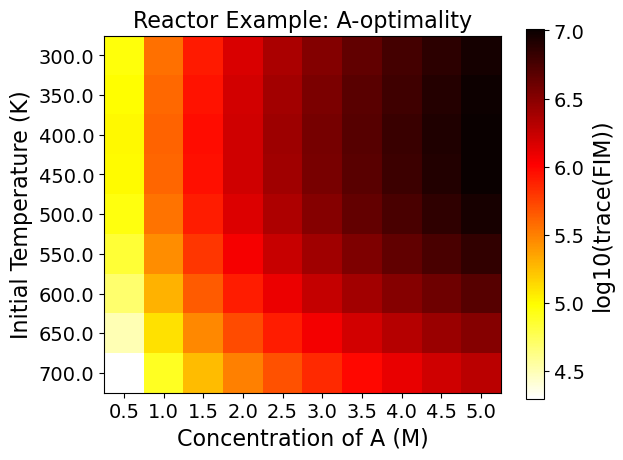

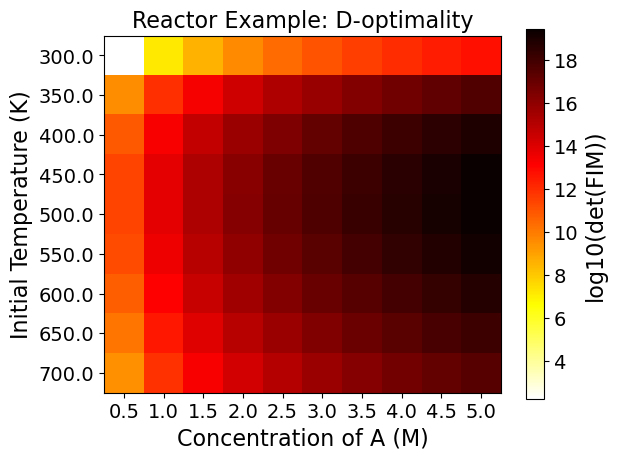

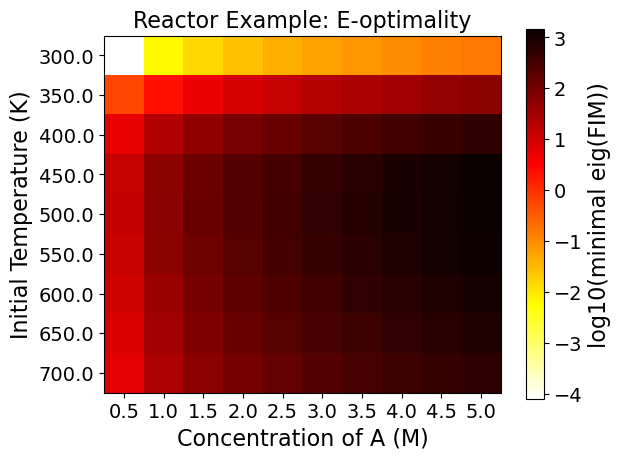

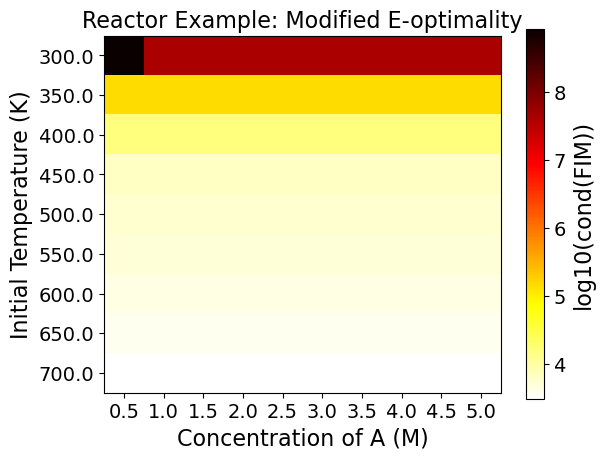

In [11]:
# Plot the results
doe_obj.draw_factorial_figure(
    sensitivity_design_variables=["CA0[0]", "T[0]"],
    fixed_design_variables={
        "T[0.125]": 300,
        "T[0.25]": 300,
        "T[0.375]": 300,
        "T[0.5]": 300,
        "T[0.625]": 300,
        "T[0.75]": 300,
        "T[0.875]": 300,
        "T[1]": 300,
    },
    title_text="Reactor Example",
    xlabel_text="Concentration of A (M)",
    ylabel_text="Initial Temperature (K)",
    figure_file_name="example_reactor_compute_FIM",
    log_scale=False,
)

As an example, the Figure from the Reactor case - D optimality shows:

The **most** informative region is around $C_{A0}=5.0 \ \text{M},$ $T=500.0 \ \text{K}$. \\
The **least** informative region is around $C_{A0}=0.5 \ \text{M},$ $T=300.0 \ \text{K}$.

This can be a lot to take in at once, but think of each square within each plot as a unique experiment.  To know what the optimality values are for an experiment set at an initial A concentration of 2.5 M and a temperature of 700 K, merely requires finding that location on the plots.

The power of viewing multiple experiments at once is that it gives a more contextualized view of the design space.  Viewing one value is also possible, but it tells less of a complete story out of the surrounding space's context.

## Step 8: Compute D-Optimal Experiment Design (Optimization)

### Computational Optimization

In [12]:
# Toggle on printing
doe_obj.tee = True

# Notice we specified the "determinant" objective when creating the DesignOfExperiments object
doe_obj.run_doe()

'pyomo.core.base.block.ScalarBlock'>) on block unknown with a new Component
(type=<class 'pyomo.core.base.block.ScalarBlock'>). This is usually indicative
of a modelling error. To avoid this warning, use block.del_component() and
block.add_component().
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
'pyomo.core.base.objective.ScalarObjective'>) on block unknown with a new
Component (type=<class 'pyomo.core.base.objective.ScalarObjective'>). This is
usually indicative of a modelling error. To avoid this warning, use
block.del_component() and block.add_component().
Ipopt 3.13.2: linear_solver=ma57
halt_on_ampl_error=yes
max_iter=3000


******************************************************************************
This program contains Ipopt, a library for large-scale non

### Extract and Summarize FIM

Next, we can summarize the FIM.

In [13]:
def results_summary(result):
    ''' Summarize the results of the experiment design
    Arguments:
    ----------
    result: The FIM matrix from the optimized experiment

    Returns:
    --------
    None
    
    Note: Taken from https://github.com/dowlinglab/pyomo-doe/blob/main/notebooks/tclab_pyomo.py

    '''
    eigenvalues, eigenvectors = np.linalg.eig(result)

    min_eig = min(eigenvalues)

    print("======Results Summary======")
    print("Four design criteria log10() value:")
    print("A-optimality:", np.log10(np.trace(result)))
    print("D-optimality:", np.log10(np.linalg.det(result)))
    print("E-optimality:", np.log10(min_eig))
    print("Modified E-optimality:", np.log10(np.linalg.cond(result)))
    print("\nFIM:\n", np.array(result))

    print("\neigenvalues:\n", eigenvalues)

    print("\neigenvectors:\n", eigenvectors)

results_summary(doe_obj.results['FIM'])

======Results Summary======
Four design criteria log10() value:
A-optimality: 6.9316222021521385
D-optimality: 19.34041799357368
E-optimality: 3.138893050718441
Modified E-optimality: 3.741473277791075

FIM:
 [[  177727.96998605    99340.89223057  -413453.83379003  -501967.36430149]
 [   99340.89223057   292556.10957161  -199008.0877333  -1435221.89445854]
 [ -413453.83379003  -199008.0877333    975791.78913822  1008806.63136677]
 [ -501967.36430149 -1435221.89445854  1008806.63136677  7097156.16924074]]

eigenvalues:
 [7.59217707e+06 9.47467067e+05 1.37687036e+03 2.21102927e+03]

eigenvectors:
 [[-0.07674202  0.37300899 -0.91723726 -0.11683652]
 [-0.19507385 -0.04024196 -0.12386907  0.97210248]
 [ 0.15779223 -0.91113555 -0.37684189 -0.05407228]
 [ 0.96496553  0.17051948 -0.03636558  0.19606679]]


### Extract and Visualize Optimal Dynamic Experiment

Finally, let's extract and plot the results of the dynamic experiment.

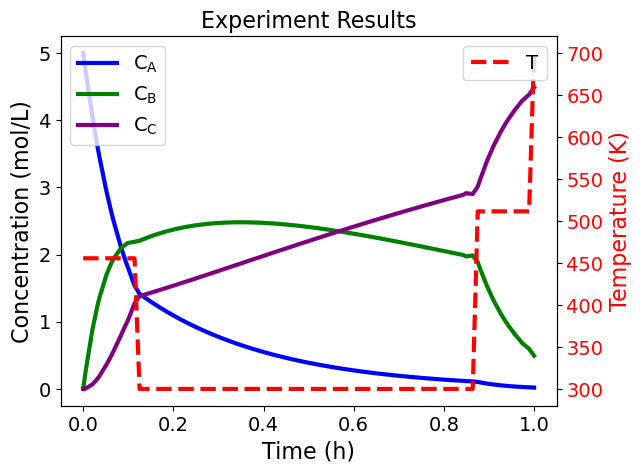

In [14]:
def plot_experiment_results(model):
    """
    Plot the results of the experiment design

    Arguments:
    ----------
    model: The Pyomo model

    Returns:
    --------
    None
    """
    # Extract the timepoints
    time = np.array([pyo.value(t) for t in model.t])

    # Extract the concentrations
    CA = np.array([pyo.value(model.CA[t]) for t in model.t])
    CB = np.array([pyo.value(model.CB[t]) for t in model.t])
    CC = np.array([pyo.value(model.CC[t]) for t in model.t])
    T = np.array([pyo.value(model.T[t]) for t in model.t])

        # Create the plot
    fig, ax1 = plt.subplots()

    # Plot concentrations on the left y-axis
    ax1.plot(time, CA, label="$C_A$", color="blue")
    ax1.plot(time, CB, label="$C_B$", color="green")
    ax1.plot(time, CC, label="$C_C$", color="purple")
    ax1.set_xlabel("Time (h)")
    ax1.set_ylabel("Concentration (mol/L)")
    ax1.legend(loc="upper left")

    # Create a second y-axis for temperature
    ax2 = ax1.twinx()
    ax2.plot(time, T, label="$T$", color="red", linestyle="--")
    ax2.set_ylabel("Temperature (K)", color="red")
    ax2.tick_params(axis='y', labelcolor="red")

    # Add legend for the temperature line
    ax2.legend(loc="upper right")

    plt.title("Experiment Results")
    plt.show()

# Plot the results of the experiment design
plot_experiment_results(doe_obj.model.scenario_blocks[0])


## Key Takeaways

* DOE is helpful for guiding decision-making by maximizing information yield in experimental design.
* FIM allows us to gain information about the data from a mathematical model in an experiment.
* Optimality conditions tells us the most and least informative regions in regards to the measurements in experimental design.
* Heatmaps enable us to visualize the most informative parameters using the optimality conditions.